In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from utils.data_loader import load_and_process_france_data

In [2]:
model = joblib.load("models/trained_models/france_prophet_model.pkl")

WARNING - (py.warnings._showwarnmsg) - c:\Users\grichard\AppData\Local\miniconda3\envs\debt-env\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



In [3]:
df = load_and_process_france_data()

In [4]:
forecast_hist = model.predict(df)

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y
INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y


In [5]:
n_years = 5
last_year = df['ds'].dt.year.max()
future_years = [last_year + i for i in range(1, n_years + 1)]

In [19]:
future_df = pd.DataFrame({
    'ds': pd.to_datetime([f"{y}-12-31" for y in future_years]),
    'ECBRate': [2.15, 2, 1.75, 1.75, 2], #* n_years,            # Example: assume ECB holds rate at 3%
    'DeficitPctGDP': [-5, -4.8, -6, -10, -5], #* n_years,      # Example: assume constant deficit at -5%
    'y' : [None] * n_years
})

In [20]:
forecast = model.predict(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y
INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 80.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y
WARNING - (py.warnings._showwarnmsg) - c:\Users\grichard\AppData\Local\miniconda3\envs\debt-env\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



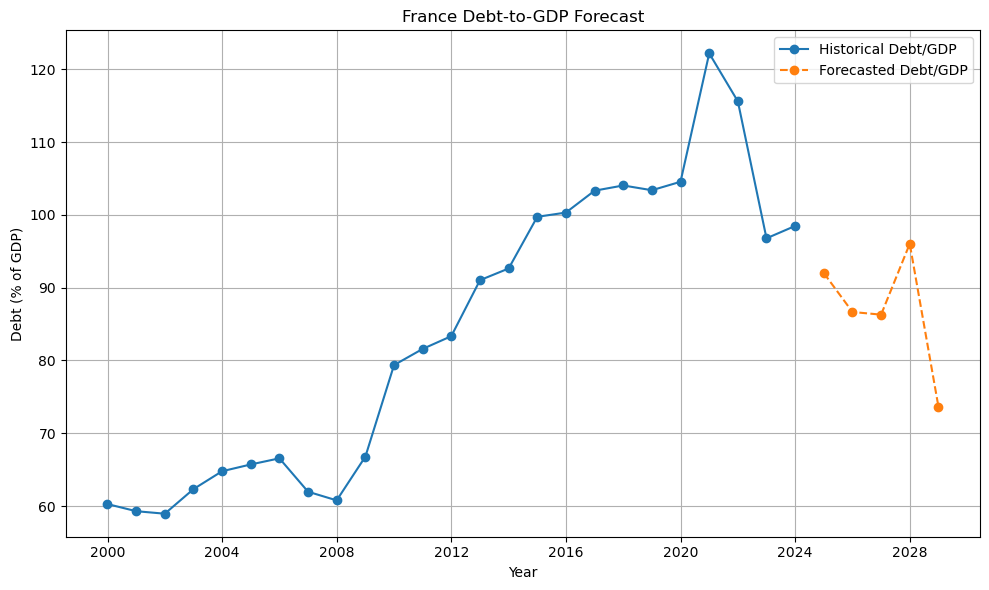

In [21]:
# 📈 5. Plot historical + forecast
plt.figure(figsize=(10, 6))

# Plot historical
plt.plot(df['ds'], df['y'], label="Historical Debt/GDP", marker='o')

# Plot forecast
plt.plot(forecast['ds'], forecast['yhat1'], label="Forecasted Debt/GDP", marker='o', linestyle='--')

plt.title("France Debt-to-GDP Forecast")
plt.xlabel("Year")
plt.ylabel("Debt (% of GDP)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Index(['ds', 'y', 'DeficitPctGDP', 'ECBRate'], dtype='object')

[Correlation Matrix]
                      y  DeficitPctGDP   ECBRate
y              1.000000      -0.538208 -0.873174
DeficitPctGDP -0.538208       1.000000  0.435130
ECBRate       -0.873174       0.435130  1.000000


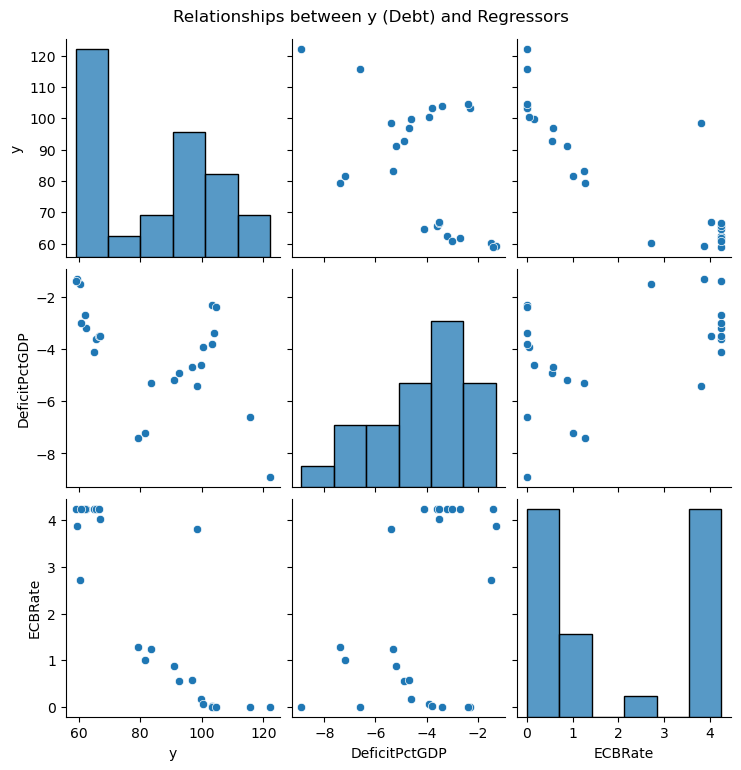

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 94.118% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 1000


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-01, min: 7.94E-07


  0%|          | 0/101 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.72E-01, min: 7.94E-07
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.40E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:13<00:00, 74.31it/s, SmoothL1Loss=0.00014, MAE=0.5, RMSE=0.684, RegLoss=0, MAE_val=9.23, RMSE_val=12.9, SmoothL1Loss_val=0.0488] 


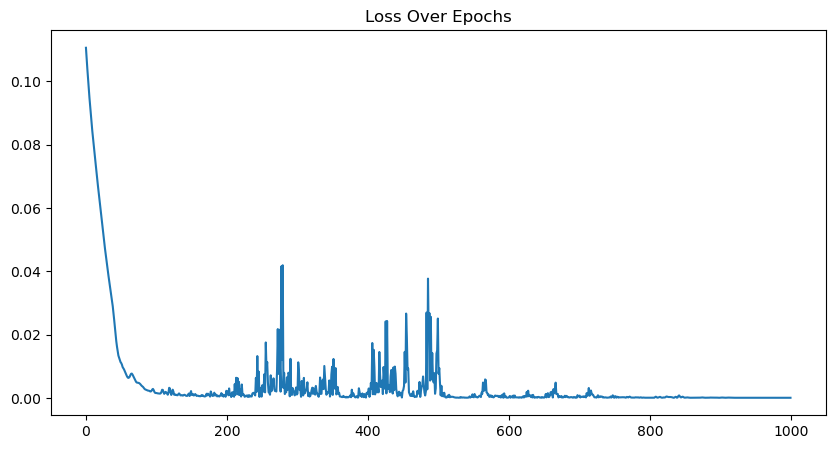

INFO - (NP.df_utils._infer_frequency) - Major frequency Y corresponds to 96.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - Y


ValueError: Future values of all user specified regressors not provided

In [31]:
# notebook_diagnostics.py

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from neuralprophet import NeuralProphet, set_random_seed
from utils.data_loader import load_and_process_france_data

# --- Step 1: Load and format data ---
# Load processed data
df = load_and_process_france_data()

# Check available columns
print(df.columns)

# Step 1: Basic correlations between y and regressors
print("\n[Correlation Matrix]")
print(df[["y", "DeficitPctGDP", "ECBRate"]].corr())

# Plot relationships
import seaborn as sns
sns.pairplot(df[["y", "DeficitPctGDP", "ECBRate"]])
plt.suptitle("Relationships between y (Debt) and Regressors", y=1.02)
plt.show()


# Step 3: Format for NeuralProphet
df_prophet = df.rename(columns={"Year": "ds", "DebtPctGDP": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

# Step 4: Split Train/Test (backtesting)
train_df = df_prophet[df_prophet["ds"].dt.year <= 2015]
val_df = df_prophet[df_prophet["ds"].dt.year > 2015]

# Step 5: Initialize and train model
set_random_seed(42)
model = NeuralProphet(
    yearly_seasonality=False,
    n_changepoints=10,
)

model.add_future_regressor("DeficitPctGDP")
model.add_future_regressor("ECBRate")

metrics = model.fit(train_df, freq="Y", validation_df=val_df)

# Step 6: Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(metrics["SmoothL1Loss"], label="Training Loss")
plt.title("Loss Over Epochs")
plt.show()

# Step 7: Forecast on full timeline + future
future = model.make_future_dataframe(df_prophet, periods=5, n_historic_predictions=True)
forecast = model.predict(future)

# Step 8: Plot forecast vs actual
model.plot(forecast)
plt.title("Debt Forecast vs Actual")
plt.show()

# Step 9: Check learned parameters (feature contributions, changepoints)
model.plot_parameters()


In [30]:
metrics

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
0,0.110557,17.386052,19.388176,0.0,0.179392,22.328522,24.774984
1,0.107023,17.141574,19.133745,0.0,0.182753,22.521299,25.005960
2,0.103819,16.930738,18.828107,0.0,0.186177,22.714836,25.239157
3,0.100679,16.720793,18.512167,0.0,0.190190,22.937855,25.509666
4,0.097633,16.546424,18.158995,0.0,0.194446,23.170326,25.793556
...,...,...,...,...,...,...,...
995,0.000140,0.499948,0.640171,0.0,0.048796,9.225649,12.921268
996,0.000140,0.499952,0.679469,0.0,0.048797,9.225699,12.921311
997,0.000140,0.499962,0.678571,0.0,0.048797,9.225723,12.921331
998,0.000140,0.499965,0.691602,0.0,0.048797,9.225729,12.921337
